In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
import requests
import time
import random
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

##Dimension reduction techniques
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA, KernelPCA
import umap

##Supervised Learning
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
from datetime import datetime
import seaborn as sns

from scipy import stats

In [2]:
##Don't put prices into group again, use heat map for better understanding
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.foundationDetails', 'resoFacts.utilities', 'resoFacts.appliances', 
                           'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))

In [3]:
Year_list = ['2022']
Month_list = ['July', 'August', 'September', 'October', 'November']

##This is a dictionary that stores the original data everymonth
original_data = dict()

##This is a dictionary that store the datasets for every month
monthly_data_dict1 = dict()

##This is a dictionary that store datasets to run analysis
monthly_data_dict2 = dict()
path_abs = "C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Houses_categorical_property\\"

##Remove zipcode, city, county, SchoolDistrict since longitude and latitude will do the part

for Year in Year_list:
    for Month in Month_list:
        main_df = pd.read_csv("C:\\Users\\Khoatruong\\DATA365\\House Capstone Project\\Data cleaning\\Clean_data_House_properties\\" + Month + '_' + Year + '\\houses_properties_' + Month + '.csv')
        cols = main_df.columns.tolist()
        
        ##Rename some columns
        for c in cols:
            if 'resoFacts.' in c:
                feature = c.split('.')[1]
                main_df[feature] = main_df[c]
                main_df.drop(labels = [c], axis = 1, inplace = True)
                
        ##Drop unimportant features 
        main_df.drop(labels = ['streetAddress', 'countyId', 'hasCooling', 'hasHeating'], axis = 1, inplace = True)
        main_df.reset_index(drop = True, inplace = True)
        
        ##Join the categorical dataframes
        for category in Selected_features:
            ft = category.split('.')[1]
            name = 'houses' + '_' + ft + '.csv'
            df_cat = pd.read_csv(path_abs + Month + '_' + Year + '\\' + name)
            main_df = pd.merge(main_df, df_cat, how = 'left', on = 'zpid')
        
        string_list = ['city', 'county', 'SchoolDistrict', 'levels']
        for string in string_list:
            main_df[string] = main_df[string].str.lower()
        original_data[Month + '_' + Year] = main_df
        
        main_df.drop(labels = ['zpid'], axis = 1, inplace = True)
        monthly_data_dict1[Month + '_' + Year] = main_df
        
        ##Remove these features for the 2D data embedding part
        remove_features = ['zipcode', 'city', 'county', 'SchoolDistrict', 'annualHomeownersInsurance']
        main_df2 = main_df.copy()
        main_df2.drop(labels = remove_features, axis = 1, inplace = True)
        monthly_data_dict2[Month + '_' + Year] = main_df2

In [4]:
category_list1 = ['zipcode', 'city', 'county', 'SchoolDistrict', 'isSeniorCommunity', 'hasAssociation', 'hasPrivatePool', 
                  'canRaiseHorses', 'hasGarage', 'hasAttachedGarage', 'hasCarport', 'hasSpa', 'hasFireplace', 
                  'levels', 'isNewConstruction']

category_list2 = ['isSeniorCommunity', 'hasAssociation', 'hasPrivatePool', 
                  'canRaiseHorses', 'hasGarage', 'hasAttachedGarage', 'hasCarport', 'hasSpa', 'hasFireplace', 
                  'levels', 'isNewConstruction']

numerical_list = ['monthlyHoaFee', 'livingAreaValue', 'bedrooms', 'longitude', 'latitude',
                  'mortgageRates.fifteenYearFixedRate', 'mortgageRates.thirtyYearFixedRate', 'mortgageRates.arm5Rate', 
                  'propertyTaxRate', 'price', 'Crime_per_1000', 'carportSpaces', 'garageSpaces', 'parking', 'coveredSpaces',
                  'bathrooms', 'bathroomsHalf', 'bathroomsFull', 'fireplaces']

In [5]:
##transform the data into values machine learning can understand
def transform_data(main_df, category_list):
    df_transformed = main_df.copy()
    for cat in category_list:
        all_values = df_transformed[cat].unique()
        if (len(all_values) == 2) and (True in all_values) and (False in all_values):
            df_transformed.loc[df_transformed[cat] == True, cat] = 1
            df_transformed.loc[df_transformed[cat] == False, cat] = 0
        elif len(all_values) > 2:
            new_ft = pd.get_dummies(df_transformed[cat], prefix = cat)
            df_transformed = pd.concat([df_transformed, new_ft], axis = 1)
            df_transformed.drop(labels = [cat], axis = 1, inplace = True)
    
    all_cols = df_transformed.columns.tolist()
    encoded_categories = sorted(set(all_cols) - set(numerical_list))
    n_list = sorted(set(numerical_list) - set(['price']))
    all_features = encoded_categories + n_list
    
    df_transformed = df_transformed[all_features + ['price']]
    ##we want to keep the list of features in order
    return all_features, df_transformed

##This will scale all the data in range of 0 to 1
def equally_scaled_data(df_transformed, numerical_list):
    df_scaled = df_transformed.copy()
    n_list = sorted(set(numerical_list) - set(['price']))
    for num_ft in n_list:
        col = df_scaled[num_ft].to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler()
        col_transformed = scaler.fit_transform(col)
        df_scaled[num_ft] = col_transformed
    return df_scaled

##favored_num: list of numerical features that seemed important, we scale them with a wider range to gain more variances
def unequal_scaled_data(df_transformed, numerical_list, favored_num, feature_range_wide):
    df_scaled = df_transformed.copy()
    n_list = sorted(set(numerical_list) - set(['price']))
    for num_ft in n_list:
        col = df_scaled[num_ft].to_numpy().reshape(-1, 1)
        if num_ft in favored_num:
            scaler1 = MinMaxScaler(feature_range_wide)
            col_transformed = scaler1.fit_transform(col)
            df_scaled[num_ft] = col_transformed
        else:
            scaler2 = MinMaxScaler(feature_range = (0, 1))
            col_transformed = scaler2.fit_transform(col)
            df_scaled[num_ft] = col_transformed
    return df_scaled

### Why scale the features with min max scaler

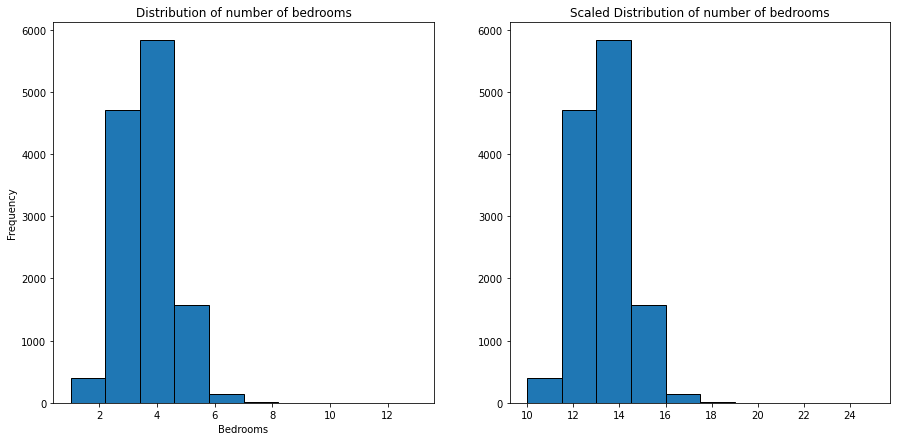

In [6]:
September_data = monthly_data_dict1['September_2022']
num_bedrooms = September_data['bedrooms'].to_numpy().reshape(-1, 1)
scaler = MinMaxScaler(feature_range = (10, 25))
num_bedrooms_transformed = scaler.fit_transform(num_bedrooms)


fig, ax = plt.subplots(1, 2, figsize = (15,7))
ax[0].hist(num_bedrooms, bins = 10, edgecolor = 'black')
ax[1].hist(num_bedrooms_transformed, bins = 10, edgecolor = 'black')
ax[0].set_title('Distribution of number of bedrooms')
ax[1].set_title('Scaled Distribution of number of bedrooms')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Bedrooms')
plt.show()

In [7]:
September_data.columns.tolist()

['annualHomeownersInsurance',
 'monthlyHoaFee',
 'livingAreaValue',
 'bedrooms',
 'longitude',
 'latitude',
 'zipcode',
 'city',
 'mortgageRates.fifteenYearFixedRate',
 'mortgageRates.thirtyYearFixedRate',
 'mortgageRates.arm5Rate',
 'propertyTaxRate',
 'price',
 'county',
 'SchoolDistrict',
 'Crime_per_1000',
 'isSeniorCommunity',
 'hasAssociation',
 'hasPrivatePool',
 'canRaiseHorses',
 'hasGarage',
 'hasAttachedGarage',
 'hasCarport',
 'carportSpaces',
 'garageSpaces',
 'parking',
 'hasSpa',
 'coveredSpaces',
 'bathrooms',
 'bathroomsHalf',
 'bathroomsFull',
 'hasFireplace',
 'fireplaces',
 'levels',
 'isNewConstruction',
 'waterSource_citywater',
 'waterSource_individualwatermeter',
 'waterSource_other',
 'architecturalStyle_traditional',
 'architecturalStyle_other',
 'architecturalStyle_contemporary/modern',
 'heating_electric',
 'heating_central',
 'heating_naturalgas',
 'heating_other',
 'heating_energystarqualifiedequipment',
 'heating_fireplace(s)',
 'heating_heatpump',
 'heat

# Basic Features analysis

In [8]:
September_data = monthly_data_dict1['September_2022']
September_data[numerical_list].corr()['price']

monthlyHoaFee                         0.293002
livingAreaValue                       0.772980
bedrooms                              0.420337
longitude                             0.019031
latitude                              0.192936
mortgageRates.fifteenYearFixedRate    0.664268
mortgageRates.thirtyYearFixedRate    -0.830510
mortgageRates.arm5Rate               -0.439575
propertyTaxRate                      -0.079690
price                                 1.000000
Crime_per_1000                       -0.115620
carportSpaces                         0.061832
garageSpaces                          0.423790
parking                               0.368687
coveredSpaces                         0.369096
bathrooms                             0.702484
bathroomsHalf                         0.372575
bathroomsFull                         0.657873
fireplaces                            0.463866
Name: price, dtype: float64

In [9]:
##This function will compare the distribution of prices based on binary categorical features
def compare_table(price1, price2, label):
    u1 = np.round(np.mean(price1), 2)
    u2 = np.round(np.mean(price2), 2)
    mean_array = np.array([[u1, u2]])
    
    std1 = np.round(np.std(price1), 2)
    std2 = np.round(np.std(price2), 2)
    std_array = np.array([[std1, std2]])
    
    median1 = np.round(np.median(price1), 2)
    median2 = np.round(np.median(price2), 2)
    median_array = np.array([[median1, median2]])
    
    mode1 = np.round(stats.mode(price1)[0][0], 2)
    mode2 = np.round(stats.mode(price2)[0][0], 2)
    mode_array = np.array([[mode1, mode2]])
    
    skew1 = np.round(stats.skew(price1), 2)
    skew2 = np.round(stats.skew(price2), 2)
    skew_array = np.array([[skew1, skew2]])
    
    kurtosis1 = np.round(stats.kurtosis(price1, fisher = False), 2)
    kurtosis2 = np.round(stats.kurtosis(price2, fisher = False), 2)
    kurtosis_array = np.array([[kurtosis1, kurtosis2]])
    
    statistics = np.concatenate((mean_array, std_array, median_array, mode_array, skew_array, kurtosis_array), axis = 0)
    df_stat = pd.DataFrame(statistics, columns = [label, 'no_' + label])
    df_temp = pd.DataFrame(pd.Series(['mean', 'std', 'median', 'mode', 'skewness', 'kurtosis']), columns = ['Statistics'])
    df_stat = pd.concat([df_temp, df_stat], axis = 1)
    df_stat.set_index(['Statistics'], inplace = True)
    return df_stat

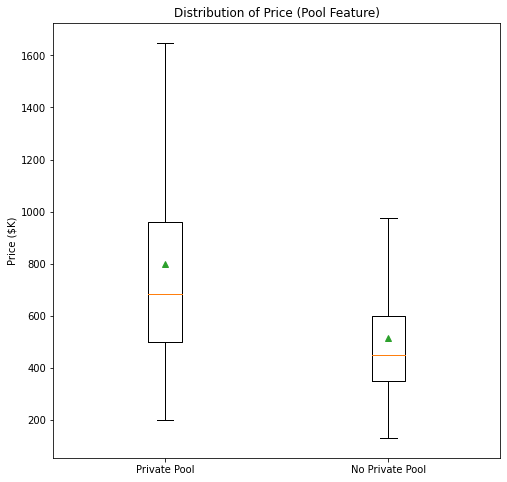

In [10]:
##Make an important note that there are a ton of outliers there
pool_dict = dict()
pool_price = September_data.loc[September_data['hasPrivatePool'] == True]['price'].to_numpy()
nopool_price = September_data.loc[September_data['hasPrivatePool'] == False]['price'].to_numpy()
pool_dict['Private Pool'] = pool_price/1000
pool_dict['No Private Pool'] = nopool_price/1000

fig, ax = plt.subplots(figsize = (8, 8))
ax.boxplot(pool_dict.values(), showfliers = False, vert = True, showmeans = True)
ax.set_xticklabels(pool_dict.keys())
ax.set_ylabel("Price ($K)")
plt.title("Distribution of Price (Pool Feature)")
plt.show()

In [11]:
#Skewness:
#If the skewness is between -0.5 & 0.5, the data are nearly symmetrical.
#If the skewness is between -1 & -0.5 (negative skewed) or between 0.5 & 1(positive skewed), the data are slightly skewed.
#If the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed), the data are extremely skewed.

#Kurtosis:
#Mesokurtic distribution: normal distribution tails (=3)
#Platykurtic distribution: tail is thinner (Data is more centered in the middle than Normal Distribution)
#Leptokurtic distribution: tail is fatter (Data is more spread out than Normal Distribution)
pool_comparison = compare_table(pool_price, nopool_price, label = 'pool')
pool_comparison

,pool,no_pool
Statistics,,
mean,799776.69,514779.02
std,407670.40,253440.13
median,685000.00,450000.00
mode,599000.00,350000.00
skewness,1.11,2.11
kurtosis,3.54,9.61


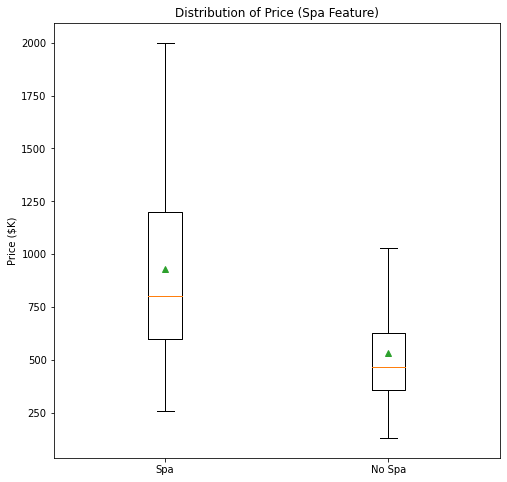

In [12]:
spa_dict = dict()
spa_price = September_data.loc[September_data['hasSpa'] == True]['price'].to_numpy()
nospa_price = September_data.loc[September_data['hasSpa'] == False]['price'].to_numpy()
spa_dict['Spa'] = spa_price/1000
spa_dict['No Spa'] = nospa_price/1000

fig, ax = plt.subplots(figsize = (8, 8))
ax.boxplot(spa_dict.values(), showfliers = False, vert = True, showmeans = True)
ax.set_xticklabels(spa_dict.keys())
ax.set_ylabel("Price ($K)")
plt.title("Distribution of Price (Spa Feature)")
plt.show()

In [13]:
spa_comparison = compare_table(spa_price, nospa_price, label = 'spa')
spa_comparison

,spa,no_spa
Statistics,,
mean,930142.14,531804.80
std,421605.89,272182.47
median,800000.00,465000.00
mode,599000.00,350000.00
skewness,0.80,2.09
kurtosis,2.70,9.04


### Lot Features

In [14]:
lotFeatures_list = [s for s in September_data.columns.tolist() if 'lotFeatures' in s]
lotFeatures_dict = dict()
for ft in lotFeatures_list:
    price_arr = September_data.loc[September_data[ft] == 1]['price'].to_numpy()/1000
    lotFeatures_dict[ft] = price_arr

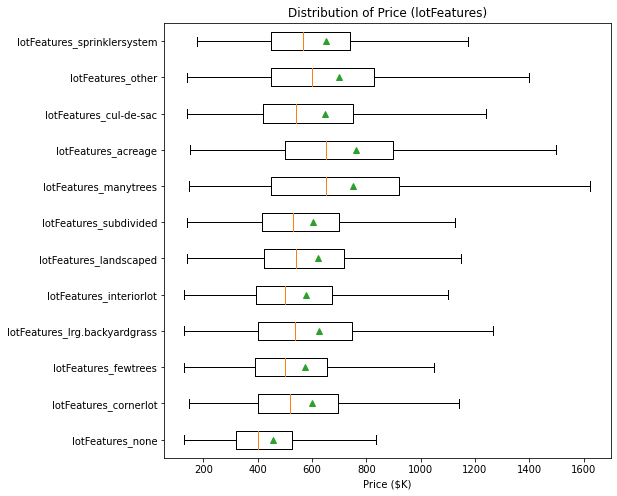

In [15]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.boxplot(lotFeatures_dict.values(), showfliers = False, vert = False, showmeans = True)
ax.set_yticklabels(lotFeatures_dict.keys())
ax.set_xlabel("Price ($K)")
plt.title("Distribution of Price (lotFeatures)")
plt.show()

In [16]:
###Create a function to do plot multiple boxplots
def multiple_boxplots(label, df):
    Features_list = [s for s in df.columns.tolist() if label in s]
    Features_dict = dict()
    for ft in Features_list:
        price_arr = df.loc[df[ft] == 1]['price'].to_numpy()/1000
        Features_dict[ft] = price_arr
    
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.boxplot(Features_dict.values(), showfliers = False, vert = False, showmeans = True)
    ax.set_yticklabels(Features_dict.keys())
    ax.set_xlabel("Price ($K)")
    plt.title("Distribution of Price (" + label + ")")
    plt.show()

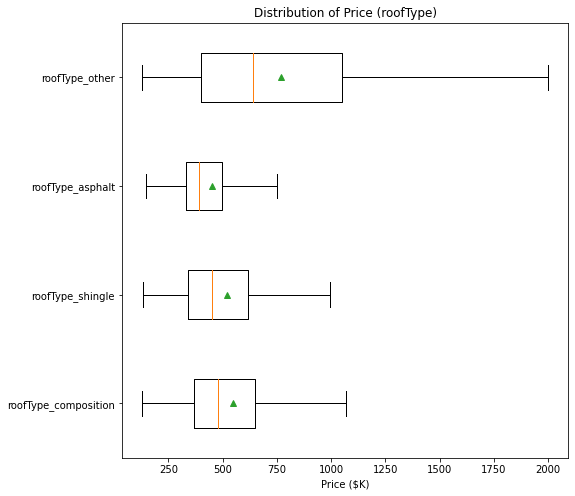

In [17]:
multiple_boxplots('roofType', September_data)

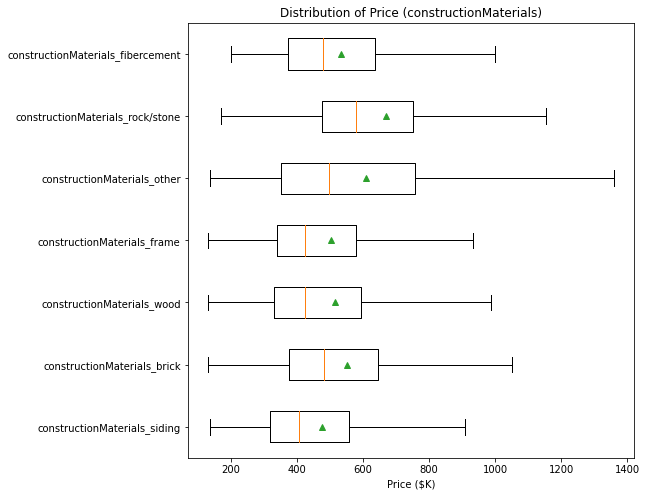

In [18]:
multiple_boxplots('constructionMaterials', September_data)

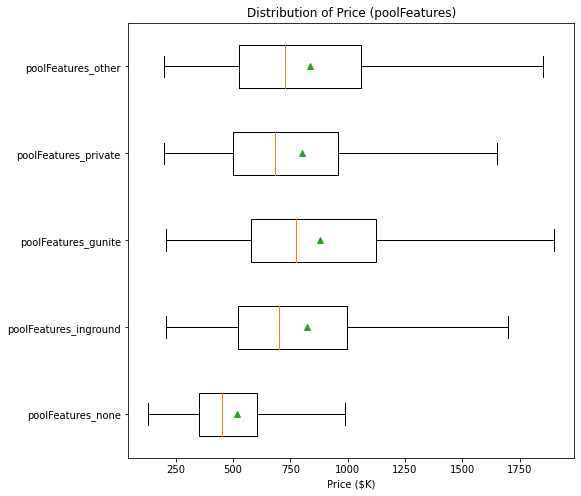

In [19]:
multiple_boxplots('poolFeatures', September_data)

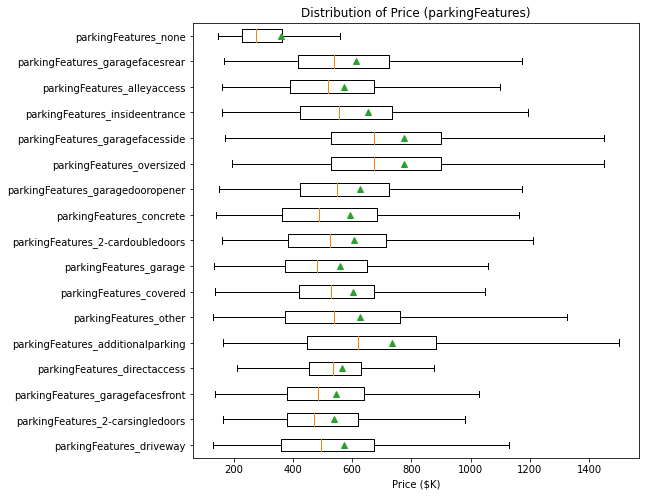

In [20]:
multiple_boxplots('parkingFeatures', September_data)

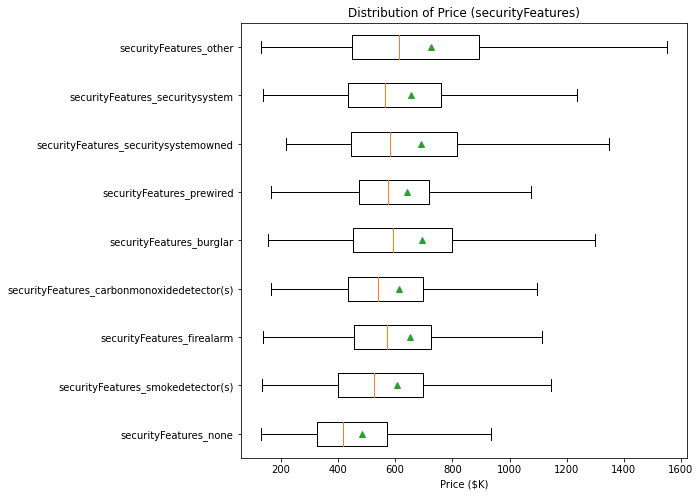

In [21]:
multiple_boxplots('securityFeatures', September_data)

# Equally Scaled and Unequally Scaled

#### Dimension reduction technique

In [22]:
tsne_2d = TSNE(n_components = 2, perplexity = 100, random_state = 0, learning_rate = 'auto', n_iter = 1200)
tsne_3d = TSNE(n_components = 3, perplexity = 100, random_state = 0, learning_rate = 'auto', n_iter = 1200)

pca_2d = PCA(n_components = 2, random_state = 0)
pca_3d = PCA(n_components = 3, random_state = 0)

kernel_pca_2d = KernelPCA(n_components = 2, kernel = 'rbf', random_state = 0)
kernel_pca_3d = KernelPCA(n_components = 3, kernel = 'rbf', random_state = 0)

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
umap_3d = umap.UMAP(n_components=3, init='random', random_state=0)

spectral_2d_rbf = SpectralEmbedding(n_components=2, affinity = 'rbf', random_state=0)
spectral_3d_rbf = SpectralEmbedding(n_components=3, affinity = 'rbf', random_state=0)

In [23]:
def embedding_data(X, target, technique, n_dimensions):
    projections = technique.fit_transform(X)
    dims = list()
    for i in range(n_dimensions):
        dims.append('x' + str(i+1))
    proj_df = pd.DataFrame(data = projections, columns = dims)
    proj_df['price'] = target
    return proj_df

def plot_2D_embedding_heatmap(projections_equal, projections_unequal, name, month):
    fig, ax = plt.subplots(1, 2, figsize = (15,7))
    st = fig.suptitle("House data 2D embedding with prices (in $k) as heatmap " + '(' + month + ')', 
                      horizontalalignment='center', verticalalignment='top', fontsize="x-large")
    
    cm = plt.cm.get_cmap('inferno')
    x1e = projections_equal['x1'].to_numpy()
    x2e = projections_equal['x2'].to_numpy()
    x1u = projections_unequal['x1'].to_numpy()
    x2u = projections_unequal['x2'].to_numpy()
    z =  projections_equal['price'].to_numpy()/1000
    
    ax0 = ax[0].scatter(x1e, x2e, c = z, vmin = 200, vmax = 800, s = 18, cmap = cm, alpha = 0.6)
    ax1 = ax[1].scatter(x1u, x2u, c = z, vmin = 200, vmax = 800, s = 18, cmap = cm, alpha = 0.6)
    ax[0].set_title(name + " 2D embedding of data (equally scaled features)")
    ax[1].set_title(name + " 2D embedding of data (unequally scaled features)")
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[1].set(xlabel = None, ylabel = None)
    plt.colorbar(ax0)
    plt.colorbar(ax1)
    fig.tight_layout()
    st.set_y(0.95)
    st.set_x(0.49)
    fig.subplots_adjust(top=0.85)
    plt.show()

#### Generate the data for dimension reduction

In [24]:
transformed_df_dict = dict()
transformed_features_dict = dict()
equal_scale_dict = dict()
unequal_scale_dict = dict()

In [25]:
feature_range_wide = (10, 25)
favored_num = ['monthlyHoaFee', 'livingAreaValue', 'bedrooms', 'longitude', 'latitude', 'mortgageRates.fifteenYearFixedRate', 
               'garageSpaces', 'parking', 'coveredSpaces', 'bathrooms', 'bathroomsHalf',
               'bathroomsFull', 'fireplaces']
for Year in Year_list:
    for Month in Month_list:
        df_original = monthly_data_dict2[Month + '_' + Year]
        all_features, df_transformed = transform_data(df_original, category_list2)
        transformed_features_dict[Month + '_' + Year] = all_features
        transformed_df_dict[Month + '_' + Year] = df_transformed
        
        equal_scale_df = equally_scaled_data(df_transformed, numerical_list)
        unequal_scale_df = unequal_scaled_data(df_transformed, numerical_list, favored_num, feature_range_wide)
        equal_scale_dict[Month + '_' + Year] = equal_scale_df
        unequal_scale_dict[Month + '_' + Year] = unequal_scale_df

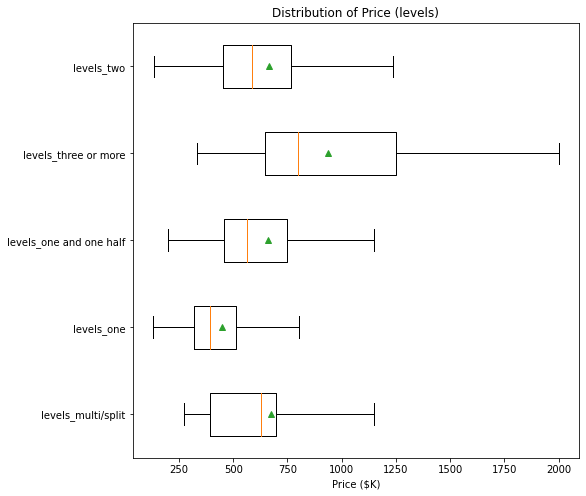

In [26]:
September_transformed = transformed_df_dict['September_2022']
multiple_boxplots('levels', September_transformed)

#### Plot the projections for one of the months (I choose September)

In [27]:
X_equal = equal_scale_dict['September_2022'].iloc[:, :-1].to_numpy()
X_unequal = unequal_scale_dict['September_2022'].iloc[:, :-1]
target = equal_scale_dict['September_2022']['price']
target

0         179900
1         189000
2         195000
3         148000
4         199000
          ...   
12673    1250000
12674    1950000
12675     899000
12676    1350000
12677     899900
Name: price, Length: 12678, dtype: int64

In [28]:
projections_equal_tsne_2d = embedding_data(X_equal, target, tsne_2d, 2)
projections_unequal_tsne_2d = embedding_data(X_unequal, target, tsne_2d, 2)

projections_equal_pca_2d = embedding_data(X_equal, target, pca_2d, 2)
projections_unequal_pca_2d = embedding_data(X_unequal, target, pca_2d, 2)

projections_equal_kernel_pca_2d = embedding_data(X_equal, target, kernel_pca_2d, 2)
projections_unequal_kernel_pca_2d = embedding_data(X_unequal, target, kernel_pca_2d, 2)

projections_equal_spectral_2d = embedding_data(X_equal, target, spectral_2d_rbf, 2)
projections_unequal_spectral_2d = embedding_data(X_unequal, target, spectral_2d_rbf, 2)

projections_equal_umap_2d = embedding_data(X_equal, target, umap_2d, 2)
projections_unequal_umap_2d = embedding_data(X_unequal, target, umap_2d, 2)

C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


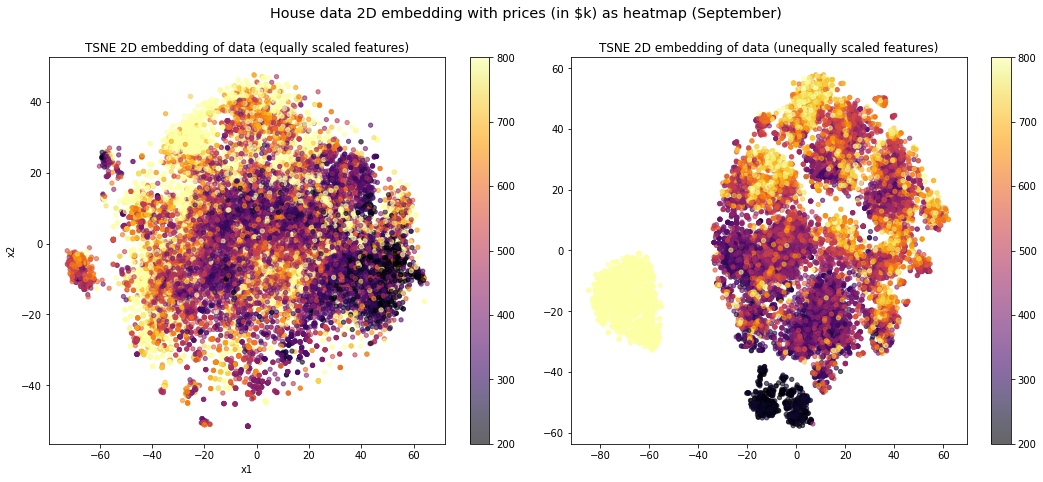

In [29]:
plot_2D_embedding_heatmap(projections_equal_tsne_2d, projections_unequal_tsne_2d, 'TSNE', 'September')

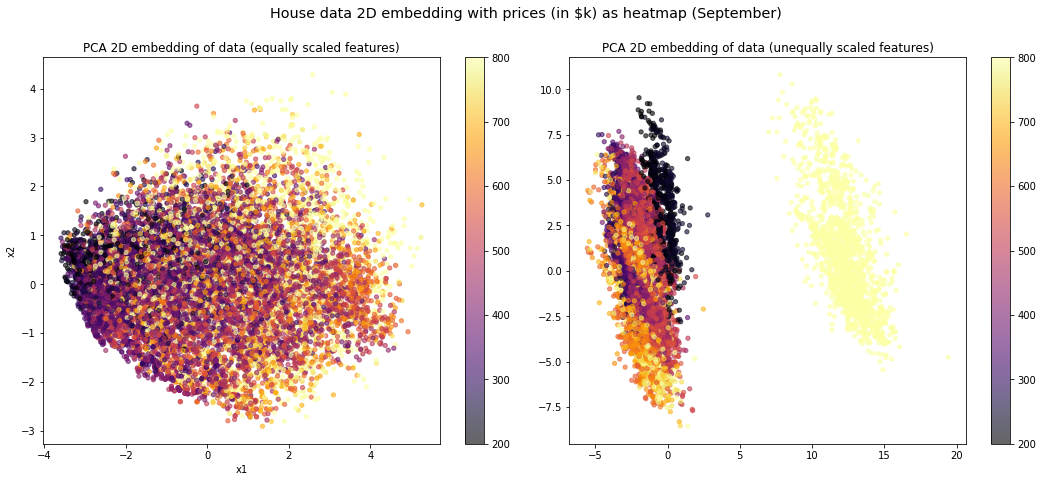

In [30]:
plot_2D_embedding_heatmap(projections_equal_pca_2d, projections_unequal_pca_2d, 'PCA', 'September')

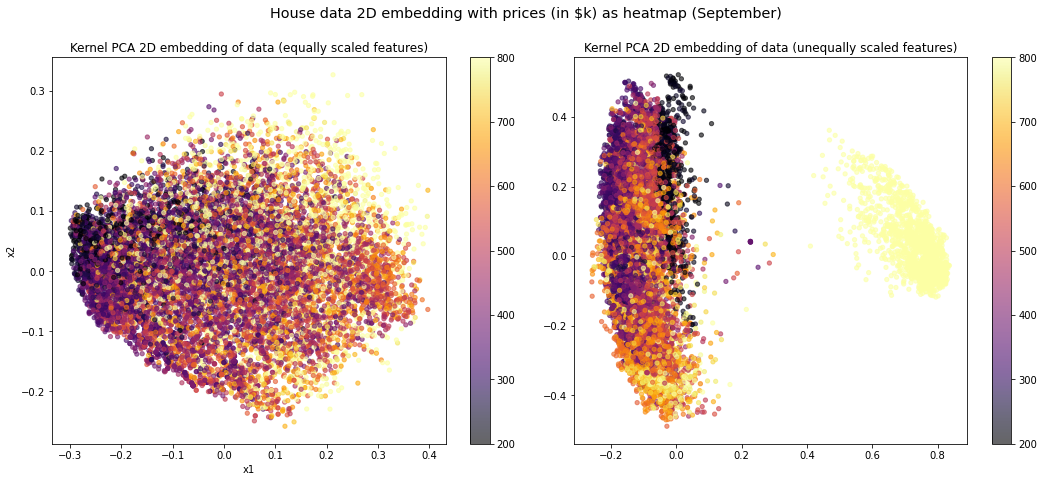

In [31]:
plot_2D_embedding_heatmap(projections_equal_kernel_pca_2d, projections_unequal_kernel_pca_2d, 'Kernel PCA', 'September')

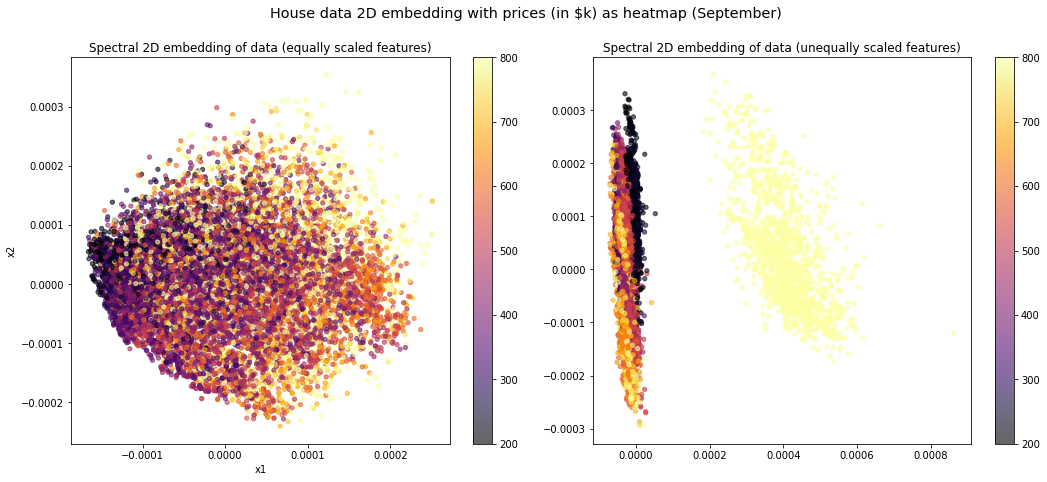

In [32]:
plot_2D_embedding_heatmap(projections_equal_spectral_2d, projections_unequal_spectral_2d, 'Spectral', 'September')

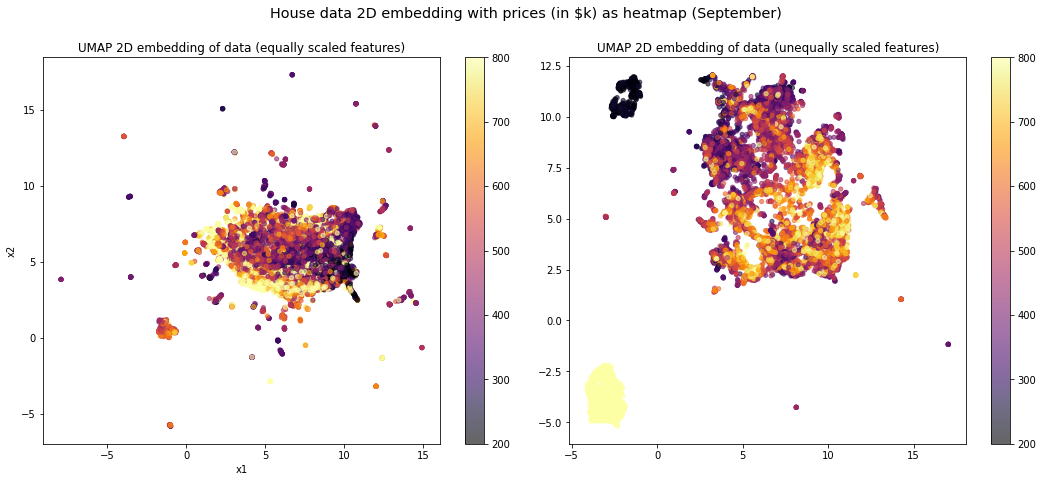

In [33]:
plot_2D_embedding_heatmap(projections_equal_umap_2d, projections_unequal_umap_2d, 'UMAP', 'September')

### Using cross_validate and nearest neighbors for the graphs

In [34]:
def cross_validation(model, projections, n_dimensions, target, cv, metrics):
    data = projections.iloc[:, :n_dimensions].to_numpy()
    results = cross_validate(estimator = model, X = data, y = target, cv = cv,
                             scoring = metrics, return_train_score = True)
    return results

In [35]:
equal_features_proj = [projections_equal_tsne_2d, projections_equal_pca_2d, projections_equal_kernel_pca_2d, 
                      projections_equal_spectral_2d, projections_equal_umap_2d]

unequal_features_proj = [projections_unequal_tsne_2d, projections_unequal_pca_2d, projections_unequal_kernel_pca_2d, 
                         projections_unequal_spectral_2d, projections_unequal_umap_2d]

In [35]:
##This table will contain the results such as r2, mae to check which visualization represents the data better
def table_results(projections_list, n_dimensions, cv, technique, metrics_regression):
    m = len(projections_list)
    results_array = np.zeros((6, m))
    for i in range(m):
        target = projections_list[i]['price'].to_numpy()
        results = cross_validation(technique, projections_list[i], n_dimensions, 
                                   target, cv, metrics_regression)
        train_r2_mean = np.round(results['train_r2'].mean(), 4)
        test_r2_mean = np.round(results['test_r2'].mean(), 4)
        train_rmse_mean = np.round((results['train_neg_root_mean_squared_error'] * -1).mean(), 4)
        test_rmse_mean = np.round((results['test_neg_root_mean_squared_error'] * -1).mean(), 4)
        train_mae_mean = np.round((results['train_neg_mean_absolute_error'] * -1).mean(), 4)
        test_mae_mean = np.round((results['test_neg_mean_absolute_error'] * -1).mean(), 4)
        
        ##Fill in the results table
        results_array[0][i] = train_r2_mean
        results_array[1][i] = test_r2_mean
        results_array[2][i] = train_rmse_mean
        results_array[3][i] = test_rmse_mean
        results_array[4][i] = train_mae_mean
        results_array[5][i] = test_mae_mean
    results_df = pd.DataFrame(results_array, index = ['train_r2_mean', 'test_r2_mean', 'train_rmse_mean', 
                                                      'test_rmse_mean', 'train_mae_mean', 'test_mae_mean'], 
                              columns = ['TSNE', 'PCA', 'KERNEL PCA', 'SPECTRAL', 'UMAP'])
    return results_df

In [37]:
KNN_r = KNeighborsRegressor(n_neighbors = 55)
n_dimensions = 2
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
metrics_regression = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']

equal_scale = table_results(equal_features_proj, n_dimensions, cv, KNN_r, metrics_regression)
equal_scale

,TSNE,PCA,KERNEL PCA,SPECTRAL,UMAP
train_r2_mean,0.4654,0.2305,0.2252,0.2246,0.3902
test_r2_mean,0.4438,0.2018,0.1967,0.1962,0.3673
train_rmse_mean,212438.5594,254871.7417,255742.4170,255838.6348,226877.4318
test_rmse_mean,216595.3513,259494.1151,260316.0962,260408.0485,231032.9567
train_mae_mean,135111.6880,172455.5636,172982.6343,173274.1200,148193.7039
test_mae_mean,138004.1969,175618.7563,176156.5345,176493.1032,151067.3899


In [38]:
unequal_scale = table_results(unequal_features_proj, n_dimensions, cv, KNN_r, metrics_regression)
unequal_scale

,TSNE,PCA,KERNEL PCA,SPECTRAL,UMAP
train_r2_mean,0.8120,0.7339,0.6999,0.7304,0.7980
test_r2_mean,0.8047,0.7225,0.6882,0.7194,0.7913
train_rmse_mean,125961.4563,149861.8481,159166.9786,150866.7047,130589.7804
test_rmse_mean,128347.3051,152975.0933,162177.5947,153816.3406,132672.3035
train_mae_mean,83485.5040,109483.7897,117747.0177,111398.3784,87260.0142
test_mae_mean,85046.5444,111575.1035,119809.8140,113479.9542,88740.6728


## Is the result consistent with every single month?

In [39]:
Month_list

['July', 'August', 'September', 'October', 'November']

In [40]:
Year_list

['2022']

In [41]:
tst2 = np.zeros((3, 5))
tst2

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [42]:
unequal_scale.loc['train_r2_mean']

TSNE          0.8120
PCA           0.7339
KERNEL PCA    0.6999
SPECTRAL      0.7304
UMAP          0.7980
Name: train_r2_mean, dtype: float64

In [43]:
tst2[0, :] = unequal_scale.loc['train_r2_mean']

In [44]:
tst2

array([[0.812 , 0.7339, 0.6999, 0.7304, 0.798 ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [45]:
##We will use all the techniques again to check
##This time only our R2 and RMSE are the metrics
KNN_r = KNeighborsRegressor(n_neighbors = 55)
n_dimensions = 2
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
metrics_regression = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
all_techniques = [tsne_2d, pca_2d, kernel_pca_2d, spectral_2d_rbf, umap_2d]
#all_name = ['TSNE', 'PCA', 'KERNEL PCA', 'SPECTRAL', 'UMAP']

#n: represents the number of months and year we will run the embedding on
def monthly_2D_embedding(n, Month_list, Year_list, unequal_scale_dict, all_techniques,
                         model, metrics_list, cv, n_dimensions):
    
    monthly_r2 = np.zeros((n,5))
    monthly_rmse = np.zeros((n,5))
    all_cb = list()
    for Year in Year_list:
        for Month in Month_list:
            print(Month)
            print(Year)
            print()
            df_temp = unequal_scale_dict[Month + '_' + Year]
            X_temp = df_temp.iloc[:, :-1].to_numpy()
            target = df_temp.iloc[:, -1].to_numpy()
            all_projections = list()
            for technique in all_techniques:
                projections = embedding_data(X_temp, target, technique, 2)
                all_projections.append(projections)
            ##The results only represent for one month
            temp_results = table_results(all_projections, n_dimensions, cv, model, metrics_list)
            idx = Month_list.index(Month)
            monthly_r2[idx, :] = temp_results.loc['test_r2_mean']
            monthly_rmse[idx, :] = temp_results.loc['test_rmse_mean']
            all_cb.append(Month + '_' + Year)
    r2_df = pd.DataFrame(monthly_r2, index = all_cb, columns = ['TSNE', 'PCA', 'KERNEL PCA', 'SPECTRAL', 'UMAP'])
    rmse_df = pd.DataFrame(monthly_rmse, index = all_cb, columns = ['TSNE', 'PCA', 'KERNEL PCA', 'SPECTRAL', 'UMAP'])
    return r2_df, rmse_df

In [46]:
n = 5
r2_df, rmse_df = monthly_2D_embedding(n, Month_list, Year_list, unequal_scale_dict, all_techniques,
                                      KNN_r, metrics_regression, cv, n_dimensions)

July
2022



C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


August
2022



C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


September
2022



C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


October
2022



C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


November
2022



C:\Users\Khoatruong\anaconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [47]:
r2_df

,TSNE,PCA,KERNEL PCA,SPECTRAL,UMAP
July_2022,0.7974,0.8208,0.7366,0.8186,0.7898
August_2022,0.8091,0.7484,0.7054,0.7423,0.7860
September_2022,0.8047,0.7225,0.6882,0.7194,0.7913
October_2022,0.8115,0.7346,0.6995,0.7292,0.8057
November_2022,0.8138,0.7418,0.7664,0.7558,0.7944


In [48]:
rmse_df

,TSNE,PCA,KERNEL PCA,SPECTRAL,UMAP
July_2022,135864.0803,127815.5337,154949.2664,128582.5511,138390.2200
August_2022,128088.4933,147077.9162,159167.3895,148830.0147,135639.7653
September_2022,128347.3051,152975.0933,162177.5947,153816.3406,132672.3035
October_2022,126791.3257,150522.0566,160134.7858,152044.6031,128731.7887
November_2022,119900.2403,141223.5869,134309.1502,137363.1495,125924.7788


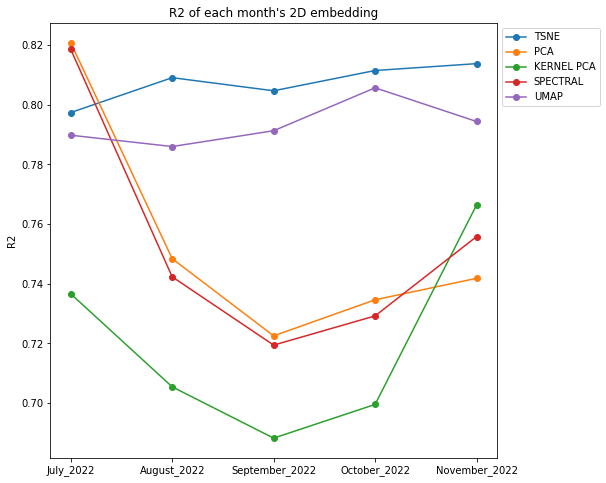

In [49]:
##plot these out for better visualization
plt.figure(figsize = (8, 8))
plt.plot(r2_df['TSNE'], '-o', label = 'TSNE')
plt.plot(r2_df['PCA'], '-o', label = 'PCA')
plt.plot(r2_df['KERNEL PCA'], '-o', label = 'KERNEL PCA')
plt.plot(r2_df['SPECTRAL'], '-o', label = 'SPECTRAL')
plt.plot(r2_df['UMAP'], '-o', label = 'UMAP')
plt.title("R2 of each month's 2D embedding")
plt.ylabel('R2')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

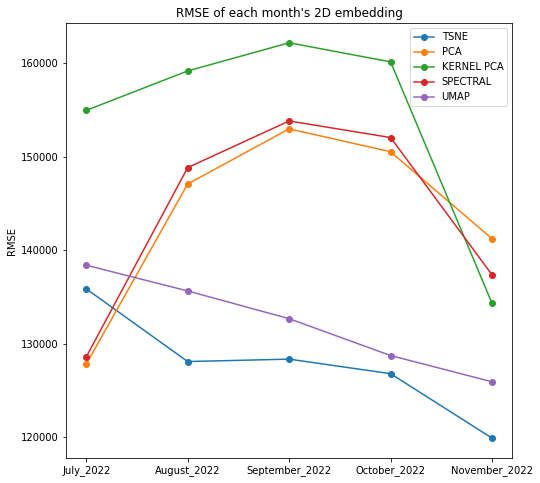

In [50]:
##plot these out for better visualization
plt.figure(figsize = (8, 8))
plt.plot(rmse_df['TSNE'], '-o', label = 'TSNE')
plt.plot(rmse_df['PCA'], '-o', label = 'PCA')
plt.plot(rmse_df['KERNEL PCA'], '-o', label = 'KERNEL PCA')
plt.plot(rmse_df['SPECTRAL'], '-o', label = 'SPECTRAL')
plt.plot(rmse_df['UMAP'], '-o', label = 'UMAP')
plt.title("RMSE of each month's 2D embedding")
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

### Supervised learning (Price prediction)

In [27]:
###We will use many different regression techniques to see if the features we have predict the data well.
df_Nov2022 = transformed_df_dict['November_2022']
df_Nov2022

,appliances_built-ingasrange,appliances_convectionoven,appliances_dishwasher,appliances_disposal,appliances_doubleoven,appliances_electriccooktop,appliances_electricoven,appliances_electricrange,appliances_electricwaterheater,appliances_gascooktop,...,latitude,livingAreaValue,longitude,monthlyHoaFee,mortgageRates.arm5Rate,mortgageRates.fifteenYearFixedRate,mortgageRates.thirtyYearFixedRate,parking,propertyTaxRate,price
0,0,0,1,0,0,0,1,0,0,0,...,33.004993,1120.0,-97.804665,0.0,5.933,5.480,6.221,0.0,1.47,289000.0
1,0,0,0,0,0,0,0,0,0,0,...,33.418247,1509.0,-97.753296,0.0,5.933,5.480,6.221,0.0,1.47,275000.0
2,0,0,0,0,0,0,1,0,0,0,...,33.174137,2847.0,-97.868740,0.0,5.933,5.480,6.221,2.0,1.47,300000.0
3,0,0,1,0,0,0,0,0,0,0,...,33.065254,2128.0,-97.738266,0.0,5.933,5.480,6.221,2.0,1.47,299999.0
4,0,0,1,0,0,0,0,1,0,0,...,33.243040,2017.0,-97.585600,0.0,5.933,5.480,6.221,2.0,1.47,289000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14147,0,0,0,0,0,0,0,0,0,0,...,32.539078,4300.0,-96.842514,63.0,5.486,5.385,5.911,2.0,1.86,899900.0
14148,0,0,1,0,0,0,0,0,0,1,...,32.524220,1626.0,-96.894200,0.0,5.486,5.385,5.911,2.0,1.86,1300000.0
14149,0,0,1,1,1,1,1,0,1,0,...,32.228120,4601.0,-96.857666,0.0,5.486,5.385,5.911,3.0,1.86,1225000.0
14150,0,0,1,1,0,1,1,0,1,0,...,32.342957,2826.0,-96.945750,0.0,5.486,5.385,5.911,2.0,1.86,1350000.0


In [36]:
##Trees don't need to rescale the data
X_Nov2022 = df_Nov2022.iloc[:, :-1].to_numpy()
y_Nov2022 = df_Nov2022.iloc[:, -1].to_numpy()

RF1 = RandomForestRegressor(n_estimators = 100, warm_start = True, random_state = 0)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
metrics_regression = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']

results_RF1 = cross_validate(estimator = RF1, X = X_Nov2022, y = y_Nov2022, cv = cv,
                             scoring = metrics_regression, return_train_score = True)

In [37]:
results_RF1

{'fit_time': array([23.9759171 , 23.77900076, 23.89780951, 23.78823781, 23.85899997]),
 'score_time': array([0.0890007 , 0.08899903, 0.09004164, 0.08999801, 0.08999896]),
 'test_r2': array([0.8924559 , 0.88377883, 0.89133923, 0.88790641, 0.89290801]),
 'train_r2': array([0.98454818, 0.98496835, 0.98420418, 0.98437436, 0.98442929]),
 'test_neg_root_mean_squared_error': array([-85562.58958376, -96132.08267294, -89904.06463562, -99754.00992954,
        -90184.64440477]),
 'train_neg_root_mean_squared_error': array([-35093.23024337, -33993.04315046, -35136.40613323, -34120.6626232 ,
        -34797.41580782]),
 'test_neg_mean_absolute_error': array([-49188.77819388, -53610.33594283, -51237.7421902 , -54188.69932917,
        -51328.62416153]),
 'train_neg_mean_absolute_error': array([-19538.91648488, -19057.48835745, -19365.20351795, -19124.68324136,
        -19366.05315409])}

In [40]:
HGB_regressor = HistGradientBoostingRegressor(learning_rate = 0.2, random_state = 0)
results_HGB = cross_validate(estimator = HGB_regressor, X = X_Nov2022, y = y_Nov2022, cv = cv,
                             scoring = metrics_regression, return_train_score = True)

In [41]:
##Tomorrow use many different techniques and see which one is good
results_HGB

{'fit_time': array([4.94000506, 2.86503148, 4.9020009 , 4.52299857, 3.4779985 ]),
 'score_time': array([0.03999448, 0.03996754, 0.04400158, 0.04500294, 0.0400002 ]),
 'test_r2': array([0.89558057, 0.8836046 , 0.89001505, 0.89409455, 0.89377408]),
 'train_r2': array([0.96886799, 0.95795403, 0.96924758, 0.96534867, 0.96214443]),
 'test_neg_root_mean_squared_error': array([-84310.42289971, -96204.11127012, -90450.20598754, -96961.4555214 ,
        -89819.236482  ]),
 'train_neg_root_mean_squared_error': array([-49812.35685773, -56852.42248882, -49025.93593479, -50811.0877712 ,
        -54257.23170924]),
 'test_neg_mean_absolute_error': array([-49844.67973382, -53540.3482246 , -51075.66918275, -52940.28327947,
        -51679.77411849]),
 'train_neg_mean_absolute_error': array([-33506.20979411, -38747.10921489, -33096.33328127, -33731.95448716,
        -37262.58955093])}

In [45]:
LR = LinearRegression()
DTR = DecisionTreeRegressor(random_state = 0)
RF = RandomForestRegressor(n_estimators = 100, random_state = 0)
ADA = AdaBoostRegressor(random_state = 0)
HGBR = HistGradientBoostingRegressor(learning_rate = 0.2, random_state = 0)

In [50]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
metrics_regression = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
all_regression = [LR, DTR, RF, ADA, HGBR]
n = 5

def monthly_price_prediction(n, Month_list, Year_list, transformed_df_dict, all_regression, metrics_list, cv):
    monthly_r2 = np.zeros((n,5))
    monthly_rmse = np.zeros((n,5))
    monthly_mae = np.zeros((n,5))
    all_cb = list()
    for Year in Year_list:
        for Month in Month_list:
            print(Month)
            print(Year)
            print()
            df_temp = transformed_df_dict[Month + '_' + Year]
            X_temp = df_temp.iloc[:, :-1].to_numpy()
            target = df_temp.iloc[:, -1].to_numpy()
            all_predictions = list()
            for model in all_regression:
                temp_results = cross_validate(estimator = model, X = X_temp, y = target, cv = cv,
                                              scoring = metrics_regression, return_train_score = True)
                all_predictions.append(temp_results)
            all_r2 = np.zeros((5,))
            all_rmse = np.zeros((5,))
            all_mae = np.zeros((5,))
            for i in range(len(all_predictions)):
                test_r2_mean = np.round(all_predictions[i]['test_r2'].mean(), 4)
                test_rmse_mean = np.round((all_predictions[i]['test_neg_root_mean_squared_error'] * -1).mean(), 4)
                test_mae_mean = np.round((all_predictions[i]['test_neg_mean_absolute_error'] * -1).mean(), 4)
                all_r2[i] = test_r2_mean
                all_rmse[i] = test_rmse_mean
                all_mae[i] = test_mae_mean
            
            idx = Month_list.index(Month)
            monthly_r2[idx, :] = all_r2
            monthly_rmse[idx, :] = all_rmse
            monthly_mae[idx, :] = all_mae
            all_cb.append(Month + '_' + Year)
    
    r2_df = pd.DataFrame(monthly_r2, index = all_cb, columns = ['LR', 'DTR', 'RF', 'ADA', 'HGBR'])
    rmse_df = pd.DataFrame(monthly_rmse, index = all_cb, columns = ['LR', 'DTR', 'RF', 'ADA', 'HGBR'])
    mae_df = pd.DataFrame(monthly_mae, index = all_cb, columns = ['LR', 'DTR', 'RF', 'ADA', 'HGBR'])
    return r2_df, rmse_df, mae_df

In [51]:
r2_df, rmse_df, mae_df = monthly_price_prediction(n, Month_list, Year_list, transformed_df_dict, 
                                                  all_regression, metrics_regression, cv)

July
2022

August
2022

September
2022

October
2022

November
2022



In [52]:
r2_df

,LR,DTR,RF,ADA,HGBR
July_2022,-1.250615e+12,0.7937,0.8932,0.8182,0.8896
August_2022,-1.094332e+13,0.7944,0.8962,0.8239,0.8960
September_2022,-6.350433e+13,0.7897,0.8937,0.8272,0.8945
October_2022,8.506000e-01,0.7965,0.8990,0.8243,0.9003
November_2022,-4.555018e+12,0.7858,0.8897,0.8148,0.8914


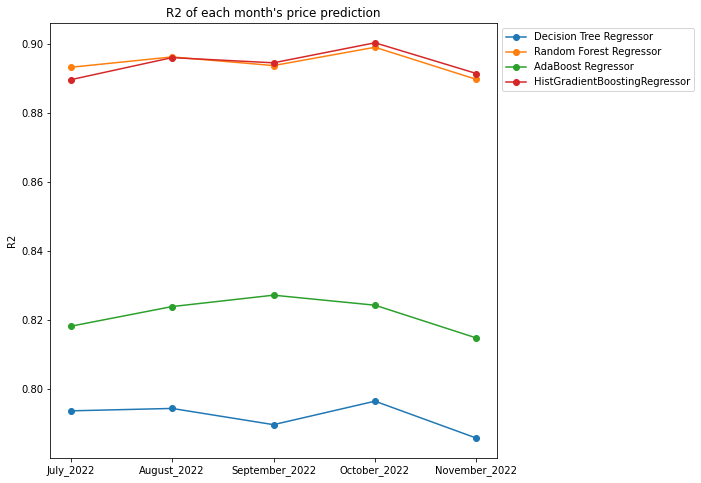

In [54]:
plt.figure(figsize = (8, 8))
plt.plot(r2_df['DTR'], '-o', label = 'Decision Tree Regressor')
plt.plot(r2_df['RF'], '-o', label = 'Random Forest Regressor')
plt.plot(r2_df['ADA'], '-o', label = 'AdaBoost Regressor')
plt.plot(r2_df['HGBR'], '-o', label = 'HistGradientBoostingRegressor')
plt.title("R2 of each month's price prediction")
plt.ylabel('R2')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [55]:
rmse_df

,LR,DTR,RF,ADA,HGBR
July_2022,1.811878e+11,137101.0938,98664.6022,128640.1958,100300.0922
August_2022,4.402533e+11,132926.6772,94498.3515,123030.6318,94581.8611
September_2022,1.035847e+12,133142.6117,94595.6953,120651.8351,94274.5516
October_2022,1.129084e+05,131730.7172,92855.1533,122480.9269,92216.0492
November_2022,2.630355e+11,128431.7054,92307.4782,119495.9300,91549.0864


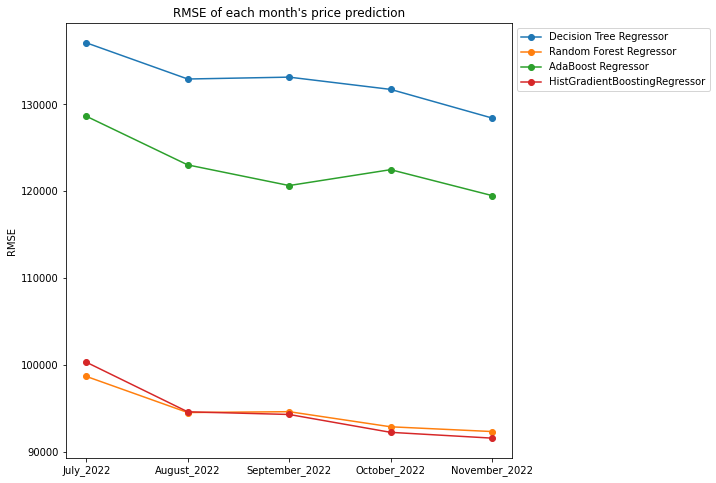

In [56]:
plt.figure(figsize = (8, 8))
plt.plot(rmse_df['DTR'], '-o', label = 'Decision Tree Regressor')
plt.plot(rmse_df['RF'], '-o', label = 'Random Forest Regressor')
plt.plot(rmse_df['ADA'], '-o', label = 'AdaBoost Regressor')
plt.plot(rmse_df['HGBR'], '-o', label = 'HistGradientBoostingRegressor')
plt.title("RMSE of each month's price prediction")
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [57]:
mae_df

,LR,DTR,RF,ADA,HGBR
July_2022,3.635289e+09,71935.4392,53794.9596,86564.9677,56664.1347
August_2022,8.115424e+09,68962.2974,51309.5694,82186.6632,52201.5396
September_2022,2.056944e+10,70523.7382,52416.3635,81209.5208,53049.1217
October_2022,7.042179e+04,69632.0230,51254.3183,81515.6207,52174.7846
November_2022,6.633791e+09,69336.5895,51910.8360,79100.5762,51816.1509


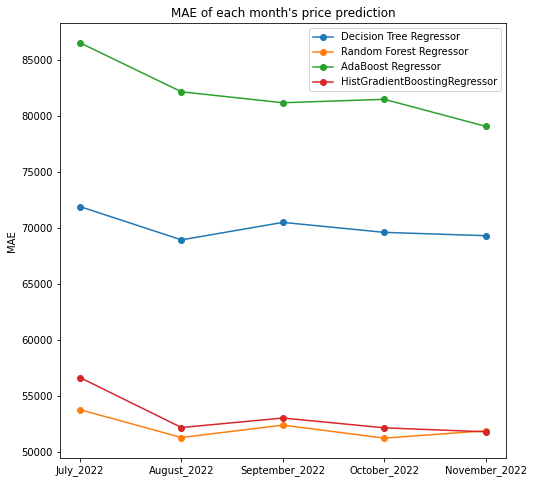

In [59]:
plt.figure(figsize = (8, 8))
plt.plot(mae_df['DTR'], '-o', label = 'Decision Tree Regressor')
plt.plot(mae_df['RF'], '-o', label = 'Random Forest Regressor')
plt.plot(mae_df['ADA'], '-o', label = 'AdaBoost Regressor')
plt.plot(mae_df['HGBR'], '-o', label = 'HistGradientBoostingRegressor')
plt.title("MAE of each month's price prediction")
plt.ylabel('MAE')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

## Time series (next semester)

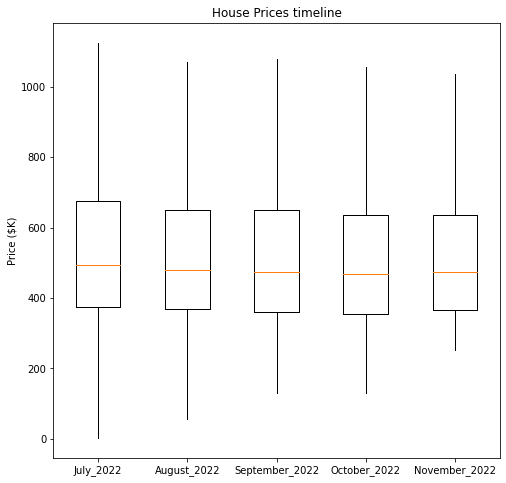

In [69]:
house_prices_dict = dict()
for Year in Year_list:
    for Month in Month_list:
        price = monthly_data_dict1[Month + '_' + Year]['price'].to_numpy()
        house_prices_dict[Month + '_' + Year] = price/1000

fig, ax = plt.subplots(figsize = (8, 8))
ax.boxplot(house_prices_dict.values(), showfliers = False, vert = True, showcaps = False)
ax.set_xticklabels(house_prices_dict.keys())
ax.set_ylabel("Price ($K)")
plt.title("House Prices timeline")
plt.show()

#### Kernel PCA -> Prediction?

In [33]:
Oct_cols = unequal_scale_dict['October_2022'].columns.tolist()
Nov_cols = unequal_scale_dict['November_2022'].columns.tolist()
sorted(set(Nov_cols) - set(Oct_cols))

['communityFeatures_fitnesscenter',
 'cooling_heatpump',
 'interiorFeatures_wiredfordata',
 'parkingFeatures_enclosed',
 'waterSource_co-opwater']

In [34]:
sorted(set(Oct_cols) - set(Nov_cols))

['fencing_chain link']

In [38]:
df_Nov2022 = transformed_df_dict['November_2022']
df_Nov2022

,appliances_built-ingasrange,appliances_convectionoven,appliances_dishwasher,appliances_disposal,appliances_doubleoven,appliances_electriccooktop,appliances_electricoven,appliances_electricrange,appliances_electricwaterheater,appliances_gascooktop,...,latitude,livingAreaValue,longitude,monthlyHoaFee,mortgageRates.arm5Rate,mortgageRates.fifteenYearFixedRate,mortgageRates.thirtyYearFixedRate,parking,propertyTaxRate,price
0,0,0,1,0,0,0,1,0,0,0,...,33.004993,1120.0,-97.804665,0.0,5.933,5.480,6.221,0.0,1.47,289000.0
1,0,0,0,0,0,0,0,0,0,0,...,33.418247,1509.0,-97.753296,0.0,5.933,5.480,6.221,0.0,1.47,275000.0
2,0,0,0,0,0,0,1,0,0,0,...,33.174137,2847.0,-97.868740,0.0,5.933,5.480,6.221,2.0,1.47,300000.0
3,0,0,1,0,0,0,0,0,0,0,...,33.065254,2128.0,-97.738266,0.0,5.933,5.480,6.221,2.0,1.47,299999.0
4,0,0,1,0,0,0,0,1,0,0,...,33.243040,2017.0,-97.585600,0.0,5.933,5.480,6.221,2.0,1.47,289000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14147,0,0,0,0,0,0,0,0,0,0,...,32.539078,4300.0,-96.842514,63.0,5.486,5.385,5.911,2.0,1.86,899900.0
14148,0,0,1,0,0,0,0,0,0,1,...,32.524220,1626.0,-96.894200,0.0,5.486,5.385,5.911,2.0,1.86,1300000.0
14149,0,0,1,1,1,1,1,0,1,0,...,32.228120,4601.0,-96.857666,0.0,5.486,5.385,5.911,3.0,1.86,1225000.0
14150,0,0,1,1,0,1,1,0,1,0,...,32.342957,2826.0,-96.945750,0.0,5.486,5.385,5.911,2.0,1.86,1350000.0


In [50]:
data = df_Nov2022.to_numpy()
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
cv.split(data)

train_set_dict = dict()
unequaltrain_scale_dict = dict()
train_target_dict = dict()

test_set_dict = dict()
unequaltest_scale_dict = dict()
test_target_dict = dict()

n_list = sorted(set(numerical_list) - set(['price']))
feature_range_wide = (10, 25)

for i, (train_index, test_index) in enumerate(cv.split(data)):
    train_set = df_Nov2022.iloc[train_index].iloc[:, :-1]
    train_target = df_Nov2022.iloc[train_index].iloc[:, -1]
    train_set_dict['Fold ' + str(i)] = train_set.copy()
    train_target_dict['Fold ' + str(i)] = train_target.copy()
    
    test_set = df_Nov2022.iloc[test_index].iloc[:, :-1]
    test_target = df_Nov2022.iloc[test_index].iloc[:, -1]
    test_set_dict['Fold ' + str(i)] = test_set.copy()
    test_target_dict['Fold ' + str(i)] = test_target.copy()
    
    for num_ft in n_list:
        train_col = train_set[num_ft].to_numpy().reshape(-1, 1)
        test_col = test_set[num_ft].to_numpy().reshape(-1, 1)
        if num_ft in favored_num:
            scaler1 = MinMaxScaler(feature_range = feature_range_wide)
            train_col_transformed = scaler1.fit_transform(train_col)
            test_col_transformed = scaler1.transform(test_col)
            train_set[num_ft] = train_col_transformed
            test_set[num_ft] = test_col_transformed
        else:
            scaler2 = MinMaxScaler(feature_range = (0, 1))
            train_col_transformed = scaler2.fit_transform(train_col)
            test_col_transformed = scaler2.transform(test_col)
            train_set[num_ft] = train_col_transformed
            test_set[num_ft] = test_col_transformed
            
    unequaltrain_scale_dict['Fold ' + str(i)] = train_set
    unequaltest_scale_dict['Fold ' + str(i)] = test_set

In [55]:
kernel_pca_100d = KernelPCA(n_components = 100, kernel = 'rbf', random_state = 0)

In [56]:
k_folds = cv.get_n_splits(data)
pca_train_set = dict()
pca_test_set = dict()

for i in range(k_folds):
    X_train = unequaltrain_scale_dict['Fold ' + str(i)].to_numpy()
    X_test = unequaltest_scale_dict['Fold ' + str(i)].to_numpy()
    pca_train = kernel_pca_100d.fit_transform(X_train)
    pca_test = kernel_pca_100d.transform(X_test)
    pca_train_set['Fold ' + str(i)] = pca_train
    pca_test_set['Fold ' + str(i)] = pca_test

In [57]:
RF2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
RF2.fit(X = unequaltrain_scale_dict['Fold 1'], y = train_target_dict['Fold 1'])

RandomForestRegressor(random_state=0)

In [59]:
RF2.score(X = unequaltest_scale_dict['Fold 1'], y = test_target_dict['Fold 1'])

0.8836765270304094

In [62]:
test_r2_array = np.zeros((5, ))
test_RMSE_array = np.zeros((5, ))
test_MAE_array = np.zeros((5, ))

for i in range(k_folds):
    RF2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
    RF2.fit(X = unequaltrain_scale_dict['Fold ' + str(i)], y = train_target_dict['Fold ' + str(i)])
    test_r2_array[i] = RF2.score(X = unequaltest_scale_dict['Fold ' + str(i)], y = test_target_dict['Fold ' + str(i)])
    prediction = RF2.predict(X = unequaltest_scale_dict['Fold ' + str(i)])
    test_RMSE_array[i] = mean_squared_error(test_target_dict['Fold ' + str(i)], prediction, squared = False)
    test_MAE_array[i] = mean_absolute_error(test_target_dict['Fold ' + str(i)], prediction)

In [68]:
print("NOV 2022 RESULTS:")
print("Mean test R2 score: ", np.round(np.mean(test_r2_array), 4))
print("Mean test RMSE score: ", np.round(np.mean(test_RMSE_array), 4))
print("Mean test MAE score: ", np.round(np.mean(test_MAE_array), 4))

NOV 2022 RESULTS:
Mean test R2 score:  0.8896
Mean test RMSE score:  92333.7527
Mean test MAE score:  51922.4631


##### October Results

In [71]:
df_Oct2022 = transformed_df_dict['October_2022']
data = df_Oct2022.to_numpy()
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
cv.split(data)

train_set_dict = dict()
unequaltrain_scale_dict = dict()
train_target_dict = dict()

test_set_dict = dict()
unequaltest_scale_dict = dict()
test_target_dict = dict()

n_list = sorted(set(numerical_list) - set(['price']))
feature_range_wide = (10, 25)

for i, (train_index, test_index) in enumerate(cv.split(data)):
    train_set = df_Oct2022.iloc[train_index].iloc[:, :-1]
    train_target = df_Oct2022.iloc[train_index].iloc[:, -1]
    train_set_dict['Fold ' + str(i)] = train_set.copy()
    train_target_dict['Fold ' + str(i)] = train_target.copy()
    
    test_set = df_Oct2022.iloc[test_index].iloc[:, :-1]
    test_target = df_Oct2022.iloc[test_index].iloc[:, -1]
    test_set_dict['Fold ' + str(i)] = test_set.copy()
    test_target_dict['Fold ' + str(i)] = test_target.copy()
    
    for num_ft in n_list:
        train_col = train_set[num_ft].to_numpy().reshape(-1, 1)
        test_col = test_set[num_ft].to_numpy().reshape(-1, 1)
        if num_ft in favored_num:
            scaler1 = MinMaxScaler(feature_range = feature_range_wide)
            train_col_transformed = scaler1.fit_transform(train_col)
            test_col_transformed = scaler1.transform(test_col)
            train_set[num_ft] = train_col_transformed
            test_set[num_ft] = test_col_transformed
        else:
            scaler2 = MinMaxScaler(feature_range = (0, 1))
            train_col_transformed = scaler2.fit_transform(train_col)
            test_col_transformed = scaler2.transform(test_col)
            train_set[num_ft] = train_col_transformed
            test_set[num_ft] = test_col_transformed
            
    unequaltrain_scale_dict['Fold ' + str(i)] = train_set
    unequaltest_scale_dict['Fold ' + str(i)] = test_set

In [72]:
kernel_pca_100d = KernelPCA(n_components = 100, kernel = 'rbf', random_state = 0)
k_folds = cv.get_n_splits(data)
pca_train_set = dict()
pca_test_set = dict()

for i in range(k_folds):
    X_train = unequaltrain_scale_dict['Fold ' + str(i)].to_numpy()
    X_test = unequaltest_scale_dict['Fold ' + str(i)].to_numpy()
    pca_train = kernel_pca_100d.fit_transform(X_train)
    pca_test = kernel_pca_100d.transform(X_test)
    pca_train_set['Fold ' + str(i)] = pca_train
    pca_test_set['Fold ' + str(i)] = pca_test

test_r2_array = np.zeros((5, ))
test_RMSE_array = np.zeros((5, ))
test_MAE_array = np.zeros((5, ))

for i in range(k_folds):
    RF2 = RandomForestRegressor(n_estimators = 100, random_state = 0)
    RF2.fit(X = unequaltrain_scale_dict['Fold ' + str(i)], y = train_target_dict['Fold ' + str(i)])
    test_r2_array[i] = RF2.score(X = unequaltest_scale_dict['Fold ' + str(i)], y = test_target_dict['Fold ' + str(i)])
    prediction = RF2.predict(X = unequaltest_scale_dict['Fold ' + str(i)])
    test_RMSE_array[i] = mean_squared_error(test_target_dict['Fold ' + str(i)], prediction, squared = False)
    test_MAE_array[i] = mean_absolute_error(test_target_dict['Fold ' + str(i)], prediction)

In [73]:
print("OCT 2022 RESULTS:")
print("Mean test R2 score: ", np.round(np.mean(test_r2_array), 4))
print("Mean test RMSE score: ", np.round(np.mean(test_RMSE_array), 4))
print("Mean test MAE score: ", np.round(np.mean(test_MAE_array), 4))

OCT 2022 RESULTS:
Mean test R2 score:  0.899
Mean test RMSE score:  92847.574
Mean test MAE score:  51250.9353


# Can we just use some features to predict the results?

In [29]:
df_July2022 = transformed_df_dict['July_2022']
df_July2022.columns.tolist()

['appliances_built-ingasrange',
 'appliances_convectionoven',
 'appliances_dishwasher',
 'appliances_disposal',
 'appliances_doubleoven',
 'appliances_electriccooktop',
 'appliances_electricoven',
 'appliances_electricrange',
 'appliances_electricwaterheater',
 'appliances_gascooktop',
 'appliances_gasoven',
 'appliances_gasrange',
 'appliances_gaswaterheater',
 'appliances_microwave',
 'appliances_other',
 'appliances_plumbedforgasinkitchen',
 'appliances_plumbedforicemaker',
 'appliances_refrigerator',
 'appliances_tanklesswaterheater',
 'appliances_ventedexhaustfan',
 'architecturalStyle_contemporary/modern',
 'architecturalStyle_other',
 'architecturalStyle_traditional',
 'canRaiseHorses',
 'communityFeatures_clubhouse',
 'communityFeatures_communitypool',
 'communityFeatures_curbs',
 'communityFeatures_greenbelt',
 'communityFeatures_joggingpath/bikepath',
 'communityFeatures_lake',
 'communityFeatures_none',
 'communityFeatures_other',
 'communityFeatures_park',
 'communityFeatur

In [30]:
df_July2022

,appliances_built-ingasrange,appliances_convectionoven,appliances_dishwasher,appliances_disposal,appliances_doubleoven,appliances_electriccooktop,appliances_electricoven,appliances_electricrange,appliances_electricwaterheater,appliances_gascooktop,...,latitude,livingAreaValue,longitude,monthlyHoaFee,mortgageRates.arm5Rate,mortgageRates.fifteenYearFixedRate,mortgageRates.thirtyYearFixedRate,parking,propertyTaxRate,price
0,0,0,0,0,0,0,0,0,0,0,...,32.999400,1316.0,-97.488280,0.0,4.455,4.369,4.930,0.0,1.47,149000.0
1,0,0,0,0,0,0,0,1,0,0,...,33.098255,2849.0,-97.649800,0.0,4.455,4.369,4.930,4.0,1.47,179000.0
2,0,0,0,0,0,0,1,0,0,1,...,33.206820,1492.0,-97.752600,0.0,4.455,4.369,4.930,1.0,1.47,195000.0
3,0,0,0,0,0,0,0,0,0,0,...,33.232525,1168.0,-97.584150,0.0,4.455,4.369,4.930,2.0,1.47,175000.0
4,0,0,0,0,0,0,0,0,0,0,...,33.218815,1072.0,-97.750490,0.0,4.455,4.369,4.930,0.0,1.47,145000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14308,0,0,1,1,0,0,0,0,0,1,...,32.453842,3525.0,-96.961170,163.0,4.391,4.454,4.704,3.0,1.86,846900.0
14309,0,0,1,1,0,0,0,0,0,1,...,32.453230,3525.0,-96.963196,163.0,4.391,4.454,4.704,3.0,1.86,870900.0
14310,0,0,1,1,0,0,0,0,0,1,...,32.454163,3578.0,-96.961610,83.0,4.391,4.454,4.704,3.0,1.86,844900.0
14311,0,0,1,1,0,0,0,0,0,1,...,32.454170,3714.0,-96.961380,163.0,4.391,4.454,4.704,3.0,1.86,831900.0


In [31]:
features_t = ['hasAssociation', 'hasAttachedGarage', 'hasCarport', 'hasFireplace', 'hasGarage', 'hasPrivatePool',
              'hasSpa', 'isNewConstruction', 'isSeniorCommunity', 'levels_multi/split', 'levels_one', 
              'levels_one and one half', 'levels_three or more', 'levels_two', 'bathrooms', 'bathroomsFull',
              'bathroomsHalf', 'bedrooms', 'carportSpaces', 'coveredSpaces', 'fireplaces', 'garageSpaces',
              'latitude', 'longitude', 'livingAreaValue', 'monthlyHoaFee', 'mortgageRates.arm5Rate',
              'mortgageRates.fifteenYearFixedRate', 'mortgageRates.thirtyYearFixedRate', 'parking',
              'propertyTaxRate', 'price']

In [32]:
df_Julytest = df_July2022.copy()[features_t]
df_Novtest = transformed_df_dict['November_2022'].copy()[features_t]

In [33]:
df_Novtest

,hasAssociation,hasAttachedGarage,hasCarport,hasFireplace,hasGarage,hasPrivatePool,hasSpa,isNewConstruction,isSeniorCommunity,levels_multi/split,...,latitude,longitude,livingAreaValue,monthlyHoaFee,mortgageRates.arm5Rate,mortgageRates.fifteenYearFixedRate,mortgageRates.thirtyYearFixedRate,parking,propertyTaxRate,price
0,0,0,0,1,0,0,0,0,0,0,...,33.004993,-97.804665,1120.0,0.0,5.933,5.480,6.221,0.0,1.47,289000.0
1,0,0,0,0,0,0,0,1,0,0,...,33.418247,-97.753296,1509.0,0.0,5.933,5.480,6.221,0.0,1.47,275000.0
2,0,1,0,1,1,0,0,0,0,0,...,33.174137,-97.868740,2847.0,0.0,5.933,5.480,6.221,2.0,1.47,300000.0
3,0,0,1,1,0,0,0,0,0,0,...,33.065254,-97.738266,2128.0,0.0,5.933,5.480,6.221,2.0,1.47,299999.0
4,0,1,1,1,1,0,0,0,0,0,...,33.243040,-97.585600,2017.0,0.0,5.933,5.480,6.221,2.0,1.47,289000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14147,1,1,0,1,1,1,0,1,0,0,...,32.539078,-96.842514,4300.0,63.0,5.486,5.385,5.911,2.0,1.86,899900.0
14148,0,1,0,1,1,0,0,0,0,0,...,32.524220,-96.894200,1626.0,0.0,5.486,5.385,5.911,2.0,1.86,1300000.0
14149,0,1,0,1,1,1,0,0,0,0,...,32.228120,-96.857666,4601.0,0.0,5.486,5.385,5.911,3.0,1.86,1225000.0
14150,0,1,0,1,1,0,0,0,0,0,...,32.342957,-96.945750,2826.0,0.0,5.486,5.385,5.911,2.0,1.86,1350000.0


In [36]:
X_Novtest = df_Novtest.iloc[:, :-1].to_numpy()
y_Novtest = df_Novtest.iloc[:, -1].to_numpy()

RF1 = RandomForestRegressor(n_estimators = 100, warm_start = True, random_state = 0)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
metrics_regression = ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']

results_RF1 = cross_validate(estimator = RF1, X = X_Novtest, y = y_Novtest, cv = cv,
                             scoring = metrics_regression, return_train_score = True)

In [37]:
results_RF1

{'fit_time': array([5.85199833, 5.81399941, 5.84700084, 5.81300044, 5.83899975]),
 'score_time': array([0.06300092, 0.06200004, 0.06300044, 0.06199956, 0.06199884]),
 'test_r2': array([0.88995045, 0.87564727, 0.88426303, 0.88967203, 0.89102829]),
 'train_r2': array([0.98382261, 0.98481129, 0.98379027, 0.98391876, 0.98393493]),
 'test_neg_root_mean_squared_error': array([-86553.52515293, -99438.23186047, -92785.25731714, -98965.26303958,
        -90972.67827197]),
 'train_neg_root_mean_squared_error': array([-35907.71014634, -34170.17313802, -35593.7796422 , -34614.52289484,
        -35345.49031572]),
 'test_neg_mean_absolute_error': array([-49653.36112359, -53999.06569445, -52604.49875386, -53922.15330929,
        -51486.31346483]),
 'train_neg_mean_absolute_error': array([-19759.1073821 , -19097.03974405, -19414.67679303, -19318.29309621,
        -19566.93587073])}

In [ ]:
##Maybe just stick with a few features only this time